In [1]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

In [2]:
# Implementation of Rauch-Tung-Striebel smoother
class RTSSmoother:
    def __init__(self, F, Q, H, R):
        self.F = np.atleast_2d(F)
        self.Q = np.atleast_2d(Q)
        self.H = np.atleast_2d(H)
        self.R = np.atleast_2d(R)
        
    def _predict(self, x, P):
        F = self.F
        Q = self.Q
        return (F@x, F@P@F.T + Q)

    def _filter_update(self, x, P, y):
        R = self.R
        H = self.H
        # Compute Kalman gain matrix
        if not np.isnan(y):
            S = H@P@H.T + R
            chol, low = cho_factor(S)
            K = cho_solve((chol, low), H@P).T
            Hx = H@x
            return (x + K@(y - Hx), P - K@S@K.T)
        else:
            return (x, P)

    def _smoother_update(self, x_now, x_next, x_forecast, P_now, P_next, P_forecast):
        F = self.F
        # Compute smoothing gain
        chol, low = cho_factor(P_forecast)
        J = cho_solve((chol, low), F @ P_now).T
        # Update
        xnew = x_now + J @ (x_next - x_forecast)
        Pnew = P_now + J @ (P_next - P_forecast) @ J.T
        return (xnew, Pnew)

    def forward_pass(self, x, P, y_list):
        """ Calling the forward pass gives us the filtering distribution.
            Args:
                x: numpy array of shape (d,) where d is the spatial dimension
                P: numpy array of shape (d, d)
                y_list: numpy array of shape (N, d) containing a list of observations at N timepoints.
                        Note that when there is no observation at time n, then set y_list[n] = np.nan
        """
        means = []
        covariances = []
        for y  in y_list:
            x, P = self._filter_update(x, P, y)
            means.append(x)
            covariances.append(P)
            x, P = self._predict(x, P)
        return np.stack(means), np.stack(covariances)

    def backward_pass(self, x, P):
        """ Calling the backward pass gives us the smoothing distribution. This should be called after applying the forward pass.
            Args:
                x: numpy array of shape (N, d) where N is the number of forward time steps and d is the spatial dimension
                P: numpy array of shape (N, d, d)
        """
        F = self.F
        N = x.shape[0]
        means = [x[-1]]
        covariances = [P[-1]]
        for n in range(N-2, -1, -1):
            # Forecast
            xf, Pf = self._predict(x[n], P[n])
            # Update
            xnew, Pnew = self._smoother_update(x[n], x[n+1], xf, P[n], P[n+1], Pf)
            means.append(xnew)
            covariances.append(Pnew)
        return np.flip(np.stack(means), axis=0), np.flip(np.stack(covariances), axis=0)

    def __call__(self, x0, P0, y_list):
        """ Compute the smoothing distribution by applying the forward and backward pass in sequence.
            Args: same as in self.forward_pass
        """
        x, P = self.backward_pass(*self.forward_pass(x0, P0, y_list))
        return x, P

Consider the following stochastic dynamical system:

$$
\frac{d}{dt}
\begin{pmatrix}
x_t \\
v_t
\end{pmatrix}
=
\underbrace{
\begin{pmatrix}
0 & 1 \\
-k & -\lambda
\end{pmatrix}
}_{=: A}
\begin{pmatrix}
x_t \\
v_t
\end{pmatrix}
+
\begin{pmatrix}
0 & 0 \\
0 & 1
\end{pmatrix}
\dot{\mathbf{W}}_t,
$$
where $k, \lambda$ are constants and $\dot{\mathbf{W}}_t$ denotes a Gaussian white noise process in $\mathbb{R}^2$. This describes the motion of a harmonic oscillator suspended in a fluid, where $x_t$ is its position and $v_t$ is its velocity.

Discretising this system via the Euler-Maruyama scheme gives us:

$$
\begin{pmatrix}
x_{n+1} \\
v_{n+1}
\end{pmatrix}
=
\left(
I + A \Delta t
\right)
\begin{pmatrix}
x_n \\
v_n
\end{pmatrix}
+
\begin{pmatrix}
0 & 0 \\
0 & \sqrt{\Delta t}
\end{pmatrix}
\boldsymbol{\xi}_n,
$$

where $\boldsymbol{\xi}_n \sim \mathcal{N}(0, I)$ for $n=0, \ldots, N-1$ are i.i.d. Gaussians.

Defining
$$
\mathbf{z}_n := (x_n, v_n)^T, \quad \mathbf{M} := I + A \Delta t,
\quad \mathbf{Q} =
\begin{pmatrix}
0 & 0 \\
0 & \Delta t
\end{pmatrix},
$$

we can express this as a discrete stochastic dynamical system
$$
\mathbf{z}_{n+1} = \mathbf{M} \mathbf{z}_n + \sqrt{\mathbf{Q}} \,\boldsymbol{\xi}_n,
$$
or equivalently,
$$
p(\mathbf{z}_{n+1} | \mathbf{z}_n) = \mathcal{N}(\mathbf{z}_{n+1} | \mathbf{M}\mathbf{z}_n, \mathbf{Q}).
$$

In [7]:
k = 0.8
lambda_ = 0.8
dt = 0.1

A = np.array([[0, 1], [-k, -lambda_]])
M = np.eye(2) + A*dt
Q = np.array([[0, 0], [0, dt]])
sqrtQ = np.array([[0, 0], [0, np.sqrt(dt)]])

# Generate stochastic dynamical system
timesteps = np.arange(0, 10-dt, dt)
np.random.seed(0)
z0 = np.random.randn(2) # Generate random initial condition
noise = np.random.randn(len(timesteps)-1, 2)
trajectory = [z0]
current_state = z0
for idx, t in enumerate(timesteps[1:]):
    next_state = M @ current_state + sqrtQ @ noise[idx]
    trajectory.append(next_state)
    current_state = next_state
trajectory = np.array(trajectory)

Text(0, 0.5, 'position (x)')

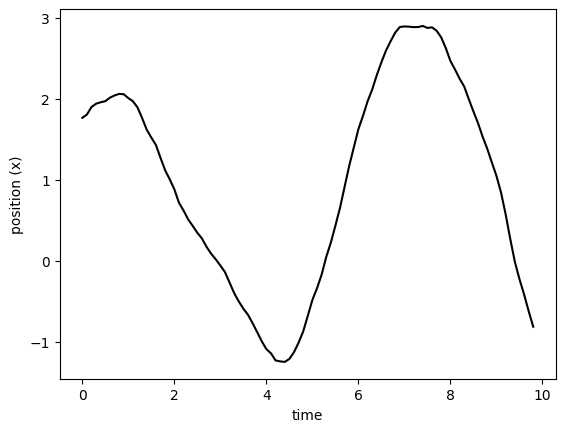

In [8]:
# Plot trajectory
plt.plot(timesteps, trajectory[:,0], 'k')
plt.xlabel("time")
plt.ylabel("position (x)")

Assume that we observe only the position ($x$) variables corrupted by noise.

$$
y_n = x_n + \eta_n,
$$
where $\eta \sim \mathcal{N}(0, \sigma^2)$. Denoting

$$
\mathbf{H} =
\begin{pmatrix}
1 & 0
\end{pmatrix}, \quad \mathbf{R} = \sigma^2
$$

we have

$$
p(y_n | \mathbf{z}_n) = \mathcal{N}(y_n | \mathbf{H}\mathbf{z}_n, \mathbf{R}), \quad n = 1, \ldots, N.
$$

In [13]:
# Generate observations
sigma = 0.5
H = np.array([1, 0])
R = np.array([sigma**2])
noise = np.random.randn(len(timesteps)-1)

y = trajectory[1:,0] + sigma * noise

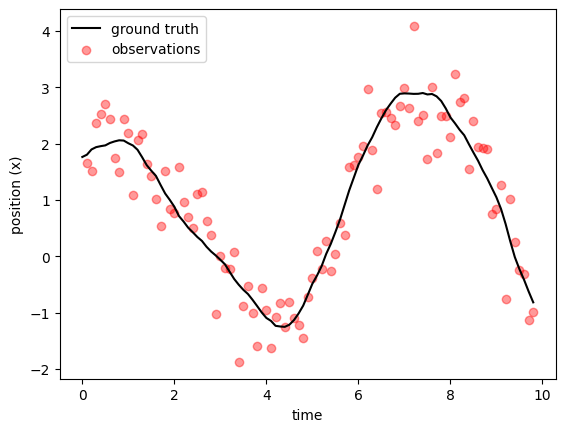

In [14]:
plt.plot(timesteps, trajectory[:,0], 'k', label='ground truth')
plt.scatter(timesteps[1:], y, c='r', alpha=0.4, label='observations')
plt.xlabel("time")
plt.ylabel("position (x)")
plt.legend()

We now apply Rauch-Tung-Striebel smoothing to recover the ground truth from the noisy observations.

We take our initial distribution to be distributed by a standard Gaussian normal.

In summary, we apply smoothing to the following system:
\begin{align*}
p(z_0) &=  \mathcal{N}(\mathbf{z}_{0} | 0, \mathbf{I}), \\
p(\mathbf{z}_{n} | \mathbf{z}_{n-1}) &= \mathcal{N}(\mathbf{z}_{n} | \mathbf{M}\mathbf{z}_{n-1}, \mathbf{Q}), \\
p(y_n | \mathbf{z}_n) &= \mathcal{N}(y_n | \mathbf{H}\mathbf{z}_n, \mathbf{R}),
\end{align*}
for $n = 1, \ldots, N$.

In [15]:
# Apply RTS smoothing
smoother = RTSSmoother(M, Q, H, R)

z0 = np.array([0,0])
P0 = np.eye(2)
y_list = np.empty(len(timesteps))
y_list[0] = np.nan # There is no observation at time 0 so we set it to NaN
y_list[1:] = y
z_pred, P_pred = smoother(z0, P0, y_list)

compute_std = lambda cov: np.sqrt(np.diag(cov))
std_pred = np.array(list(map(compute_std, P_pred)))

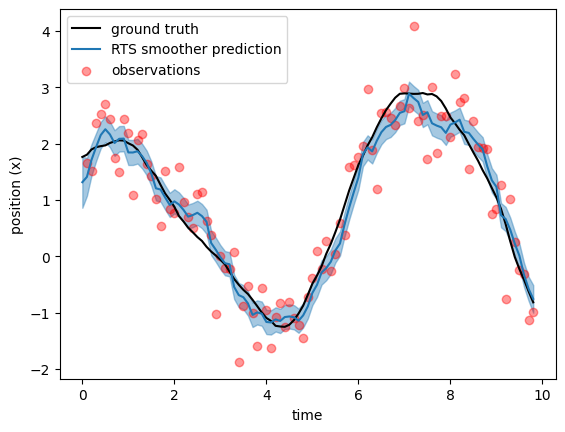

In [16]:
# Plot results from smoother
plt.plot(timesteps, trajectory[:,0], color='k', label='ground truth')
plt.plot(timesteps, z_pred[:,0], color='C0', label='RTS smoother prediction')
plt.fill_between(timesteps, z_pred[:,0]-std_pred[:,0], z_pred[:,0]+std_pred[:,0], color='C0', alpha=0.4)
plt.scatter(timesteps[1:], y, c='r', alpha=0.4, label='observations')
plt.xlabel("time")
plt.ylabel("position (x)")
plt.legend()